In [809]:
import pandas as pd
import camelot
import time
import numpy as np
import re
import glob 
import re

In [810]:
pd.options.display.max_colwidth = 20

In [811]:
# Read in original pdf file using camelot and transform it into dataframes.

# tables = camelot.read_pdf("raw.pdf", flavor='lattice', pages='1-end')

In [812]:
# Save parsed dataframes into csv.

# for i, table in enumerate(tables):
#     table.df.to_csv(f"data/{i}.csv", index=False, header=False)

# Read in saved CSV files

In [813]:
# Read in all csv files and save as list of dataframes.

filenames = glob.glob("data/*.csv")
onlynumbers = [filename[5:-4] for filename in filenames]
numbers = sorted([int(num) for num in onlynumbers])

dataframes = []
for num in numbers:
    dataframes.append(pd.read_csv(f"data/{num}.csv"))

# Remove the first three tables, which are not real data, but an example tables from the document.
dataframes = dataframes[3:]

default_columns = dataframes[0].columns.str.replace(r'\n','', regex=True)
default_columns = [col for col in default_columns if col != 'NO']

# Strip all \n from cell values
# Handle Error Cases
# Standardize Column format
for idx, dataframe in enumerate(dataframes):
    dataframe.replace(r'\n','', regex=True, inplace=True)
    dataframe.columns = dataframe.columns.str.replace(r'\n','', regex=True)
    
    dataframe.rename(columns={
        "*허가일*변경일" : "허가및변경일"
    }, inplace=True)
    
    dataframe.rename(columns={
        "NO 대표자" : "대표자"
    }, inplace=True)
    
    try:
        dataframes[idx] = dataframe[default_columns]
    except Exception as e:
        error_msg = e
        
        if str(error_msg) == "\"['용량(MW)', '허가및변경일'] not in index\"":
            dataframe.rename(columns={
                "Unnamed: 6" : "허가및변경일",
                "용량허가및변경(MW)일" : "용량(MW)"
            }, inplace=True)
            dataframes[idx] = dataframe[default_columns]
        else:
            print(f"Problem with Columns in Dataframe {idx} : {error_msg}")

In [814]:
# Concatenate all tables into a single master df

df = pd.concat(dataframes, ignore_index=True)

# Create column names

df.columns = ['owner', 'company', 'address', 'type', 'capacity_MW', 'approval_date', 'prep_time', 'note']

# Remove all rows with no cell values

df = df[~df.isnull().all(axis=1)]

In [815]:
quote_missing = df.approval_date.isna() & df.prep_time.notnull()
df.loc[quote_missing, "approval_date"] = df.loc[quote_missing, "approval_date"].fillna("“")

# Replace '“', '\"' values with proper cell values.

for column in df.columns:
    missing_index = df[(df[column] == '“') | (df[column] == '\"') | (df[column] == '‘“')].index.values.astype(int)
    for index in missing_index:
        df[column][index] = df[column][index-1]

df = df[~df.isnull().all(axis=1)]
df.reset_index(drop=True, inplace=True)

In [816]:
# Some "owner" cells include company names. 
# If owner cell has two words and the company cell is empty,
# transfer the second word from the owner cell to the company cell.

company_in_owner_col_filt = (df['owner'].str.split().str.len() > 1) & df['company'].isna()

companies_and_owners = df.loc[company_in_owner_col_filt, 'owner'].str.split()

owners = companies_and_owners.apply(lambda l: l[0])
companies = companies_and_owners.apply(lambda l: l[1])

df.loc[company_in_owner_col_filt, 'owner'] = owners
df.loc[company_in_owner_col_filt, 'company'] = companies


# Some "address" cells include company names. 

# If the company cell is empty and address cell is not, transfer the company name from the address cell to the company cell.

company_in_address_col_filt = df['approval_date'].notnull() & df['address'].notnull() & df['owner'].notnull() & df['company'].isna()

companies_and_adddress = df.loc[company_in_address_col_filt, 'address'].str.split()

companies = companies_and_adddress.apply(lambda l: l[0])
addresses = companies_and_adddress.apply(lambda l: " ".join(l[1:]))

df.loc[company_in_address_col_filt, 'company'] = companies
df.loc[company_in_address_col_filt, 'address'] = addresses



# Combine overflowing rows into a single row.

In [817]:
def concat(v1, v2):
    result = ""
    if v1 is not np.nan:
        result += str(v1)
    if result:
        result += " "
    if v2 is not np.nan:
        result += str(v2)
    if not result:
        result = np.nan
    return result

In [818]:
def roll_up(df):
    for idx in reversed(df[df["approval_date"].isna()].index):
        df.loc[idx-1] = df.loc[idx-1].combine(df.loc[idx], concat)
        df.drop(index=idx, inplace=True)
    df.reset_index(drop=True, inplace=True)

In [819]:
roll_up(df)

# Replace NaN in note column to "신규" (newly approved)

In [820]:
df.note.fillna('신규', inplace=True)
df.note = df.note.str.replace(" ", "") \
    .str.replace("nan", "신규") \
    .str.replace("nannan", "신규") \
    .str.replace("신규신규", "신규")

# Check non-Nan values in note to see if they are also onewly approved.


# searchfor = ['og', 'at']
# s[s.str.contains('|'.join(searchfor))]

not_new = ['연장', '변경', '취득', '용량', '정정', '재발급', '신규', '인가', '양수', '추가', '합병', '증설', '양도', '개시', '반납', '취소', '축소', '준비기간', '조정', '법인', 'SRF', "→", '지번', '재교부', '전환', '수정', '발전', '종류', '공급', '폐기물', '배방읍', '구분']


df.loc[~df.note.str.contains('|'.join(not_new)), "note"] = "신규"


## Convert "approval_date" from df_new to datetime

In [821]:
# Only select plants that are newly approved

df_new = df[df.note=='신규']

In [822]:
df_new

,owner,company,address,type,capacity_MW,approval_date,prep_time,note
0,이건우,강원풍력발전(주),강원도 평창군 도암면횡계리,풍력,"98,000kw",`02.6.11,2005.10.31,신규
1,후란쓰이스링거,코리아카본블랙(주)여수발전소,전남 여수시 월내동 350,부생가스,"13,900×22,500×1기",‘02.6,2002.8.31,신규
2,후란쓰이스링거,코리아카본블랙(주)부평발전소,인천시 부평구 갈산1동94,부생가스,"12,500Kw",‘02.6,2002.8.31,신규
3,이호인,(주)상원이엔씨매립가스,인천시 서구 백석동 58,내연기관(매립가스),"13,500×5기1,000×3...",‘02.9,2002.12.31,신규
4,김영철,한국중부발전(주)보령발전소,충남 보령시 오천면오포리 산 212,석탄,총580만KW,‘02.9,7호기‘08.6.308호기‘0...,신규
...,...,...,...,...,...,...,...,...
2707,박영실,오도해도리,전남 고흥군 도덕면 오마...,태양광,28.89,2022-09-21,2031-03-31,신규
2739,선선규,고흥솔라,전남 고흥군 도덕면 오마...,태양광,15.0,2022-09-20,2024-06-30,신규
2745,"정춘돌,페라다크파타나찬",조도풍력발전,전남 진도군 조도면 외병...,풍력(해상),517.08,2022-09-21,2031-10-31,신규
2746,"윤의순,송홍렬",문도해상풍력,근 )전남 여수시 거문도 ...,풍력(해상),440 nan,2022-09-21,2031-06-30,신규


In [823]:
df_new.approval_date = df_new.approval_date.str.replace("`", "20", regex=False).str.replace("‘", "20", regex=False).str.replace("'", "20", regex=False).str.replace(".", "-", regex=False)



/var/folders/_c/dcjy1m9109bd_sq8l8j8zsdr0000gn/T/ipykernel_42160/3151994482.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.approval_date = df_new.approval_date.str.replace("`", "20", regex=False).str.replace("‘", "20", regex=False).str.replace("'", "20", regex=False).str.replace(".", "-", regex=False)


In [824]:
df_new.approval_date = df_new.approval_date \
                        .str.replace(r"^12-5$", "2011-12-05", regex=True) \
                        .str.replace(r"^3-5$", "2012-03-05", regex=True) \
                        .str.replace(r"^3-30$", "2012-03-30", regex=True) \
                        .str.replace(r"^4-26$", "2012-04-26", regex=True) \
                        .str.replace(r"^12-6-4$", "2012-06-04", regex=True)


/var/folders/_c/dcjy1m9109bd_sq8l8j8zsdr0000gn/T/ipykernel_42160/2576228291.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.approval_date = df_new.approval_date \


In [825]:
df_new['year'] = df_new.approval_date.str[:4]

/var/folders/_c/dcjy1m9109bd_sq8l8j8zsdr0000gn/T/ipykernel_42160/4060278337.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['year'] = df_new.approval_date.str[:4]


In [826]:
df_new[df_new['year']== '12-6' ]

,owner,company,address,type,capacity_MW,approval_date,prep_time,note,year


In [827]:
month_regex = r"\d{4}-(\d{1,2})"

def string_to_month(string):
    month = re.findall(month_regex, string)[0]
    return month

df_new['month'] = df_new.approval_date.apply(lambda x: string_to_month(x))
df_new['month'] = df_new['month'].str.zfill(2)

df_new['cleaned_approval_time'] = df_new['year'] + "-" + df_new['month']

/var/folders/_c/dcjy1m9109bd_sq8l8j8zsdr0000gn/T/ipykernel_42160/429159645.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['month'] = df_new.approval_date.apply(lambda x: string_to_month(x))
/var/folders/_c/dcjy1m9109bd_sq8l8j8zsdr0000gn/T/ipykernel_42160/429159645.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['month'] = df_new['month'].str.zfill(2)
/var/folders/_c/dcjy1m9109bd_sq8l8j8zsdr0000gn/T/ipykernel_42160/429159645.py:10: SettingWithCopyWarning: 
A value is trying to be set o

In [828]:
df_new['cleaned_approval_time'] = pd.to_datetime(df_new['cleaned_approval_time'], format="%Y-%m")

/var/folders/_c/dcjy1m9109bd_sq8l8j8zsdr0000gn/T/ipykernel_42160/1176342324.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['cleaned_approval_time'] = pd.to_datetime(df_new['cleaned_approval_time'], format="%Y-%m")


# Clean up "용량(MW)" (capacity) column into a consistent format

In [829]:
# 1. If the cell is in KW, change the number and unit to MW.

df_in_kw = df_new[df_new['capacity_MW'].str.lower().str.contains("kw", na=False)]

# Identify which cells have multiple plants, so I can multiply the capacity by two later on.
has_multiple_plants = df_in_kw['capacity_MW'].str.contains("기")

# df.capacity_MW["kw" in df.capacity_MW.str.lower()]
has_10k = df_in_kw['capacity_MW'].str.contains("만")
has_1k = df_in_kw['capacity_MW'].str.contains("천")

df_in_kw.loc[has_10k, 'cleaned_capacity'] = df_in_kw['capacity_MW'].str.replace("만", "0000")
df_in_kw.loc[has_10k & has_1k, 'cleaned_capacity'] = df_in_kw['capacity_MW'].str.replace("만", "").str.replace("천", "000")

# Fill in empty 'cleaned_capacity' column with 'capacity_MW' values.
df_in_kw.cleaned_capacity = df_in_kw.cleaned_capacity.fillna(df_in_kw.capacity_MW)

# Convert capacity value into int and divide capacity by 1,000
df_in_kw.cleaned_capacity = df_in_kw.cleaned_capacity \
                                .str.lower() \
                                .str.replace("총", "") \
                                .str.replace("kw", "") \
                                .str.replace(",", "") \
                                .str.replace("7-8호기", "") \
                                .str.replace("2기", "")

df_in_kw.cleaned_capacity = df_in_kw.cleaned_capacity.astype(float)
df_in_kw.cleaned_capacity = df_in_kw.cleaned_capacity / 1000
df_in_kw[has_multiple_plants].cleaned_capacity = df_in_kw[has_multiple_plants].cleaned_capacity * 2


df_in_kw['capacity_MW'] = df_in_kw['cleaned_capacity']
df_in_kw.drop(columns=['cleaned_capacity'], inplace=True)

df_new.loc[df_in_kw.index, 'capacity_MW'] = df_in_kw['capacity_MW']


/var/folders/_c/dcjy1m9109bd_sq8l8j8zsdr0000gn/T/ipykernel_42160/1804820724.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_kw.loc[has_10k, 'cleaned_capacity'] = df_in_kw['capacity_MW'].str.replace("만", "0000")
/var/folders/_c/dcjy1m9109bd_sq8l8j8zsdr0000gn/T/ipykernel_42160/1804820724.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_kw.cleaned_capacity = df_in_kw.cleaned_capacity.fillna(df_in_kw.capacity_MW)
/var/folders/_c/dcjy1m9109bd_sq8l8j8zsdr0000gn/T/ipykernel_42160/1804820724.py

In [830]:
# 2. Check if there are other problems with the capacity_MW columns

# Remove all commas and "MW" from values.
df_new.capacity_MW = df_new.capacity_MW.astype(str)\
                        .str.lower() \
                        .str.replace(",", "") \
                        .str.replace("mw", "") \
                        .str.replace("nan", "") \
                        .str.replace("!", "1") \
                        .str.replace(r"×?1기", "")

# Remove additional information from capacity_MW cells.
has_additional_info = df_new.capacity_MW.str.contains("\(") & df_new.capacity_MW.str.contains("\)")
df_new["capacity_MW"] = df_new["capacity_MW"].str.replace(r"[(].*[)]", "", regex=True)



/var/folders/_c/dcjy1m9109bd_sq8l8j8zsdr0000gn/T/ipykernel_42160/664745217.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace(r"×?1기", "")
/var/folders/_c/dcjy1m9109bd_sq8l8j8zsdr0000gn/T/ipykernel_42160/664745217.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.capacity_MW = df_new.capacity_MW.astype(str)\
/var/folders/_c/dcjy1m9109bd_sq8l8j8zsdr0000gn/T/ipykernel_42160/664745217.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [831]:
# Additional manual cleaning

df_new.capacity_MW = df_new.capacity_MW.str.replace("13900×22500", "36400") \
                                        .str.replace("834.3\(gt2기 st", "834.3") \
                                        .str.replace("13500×5기1000×3기380", "70880") \
                                        .str.replace("여수250군장122.9", "372.9") \
                                        .str.replace("126313.67.3", "1283.9") \
                                        .str.replace("555.17.2", "762.3") \
                                        .str.replace("19.99 3.0", "19.993") \
                                        .str.replace(" ", "") \
                                        .str.strip() \
                                        .str.replace("82219.2", "841.2") \

# There are three entries with empty capacity, where its 9.9 capacity is placed within the energy type. Fix these entires.
df_new.loc[df_new.capacity_MW == "", 'capacity_MW'] = df_new[df_new.capacity_MW == ""]["capacity_MW"].str.replace("", "9.9")



/var/folders/_c/dcjy1m9109bd_sq8l8j8zsdr0000gn/T/ipykernel_42160/2762735152.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace("834.3\(gt2기 st", "834.3") \
/var/folders/_c/dcjy1m9109bd_sq8l8j8zsdr0000gn/T/ipykernel_42160/2762735152.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace("여수250군장122.9", "372.9") \
/var/folders/_c/dcjy1m9109bd_sq8l8j8zsdr0000gn/T/ipykernel_42160/2762735152.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace("126313.67.3", "1283.9") \
/var/folders/_c/dcjy1m9109bd_sq8l8j8zsdr0000gn/T/ipykernel_42160/2762735152.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace("555.17.2", "762.3") \
/var/folders/_c/dcjy1m9109bd_sq8l8j8zsdr0000gn/T/ipykernel_42160/2762735152.py:9: FutureWarning: The default value of regex will c

In [832]:
# Some capacity numbers are unreasonbly high, and may actually be in kw. Identify these entries.

df_new.capacity_MW = df_new.capacity_MW.astype(float)
df_new[df_new.capacity_MW>1000]

df_new.loc[df_new.capacity_MW >= 35000, 'capacity_MW'] = df_new[df_new.capacity_MW >= 35000]["capacity_MW"]/1000

/var/folders/_c/dcjy1m9109bd_sq8l8j8zsdr0000gn/T/ipykernel_42160/2269208049.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.capacity_MW = df_new.capacity_MW.astype(float)


/var/folders/_c/dcjy1m9109bd_sq8l8j8zsdr0000gn/T/ipykernel_42160/2724033507.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_new.resample('M', on="cleaned_approval_time").sum().plot()


<AxesSubplot: xlabel='cleaned_approval_time'>

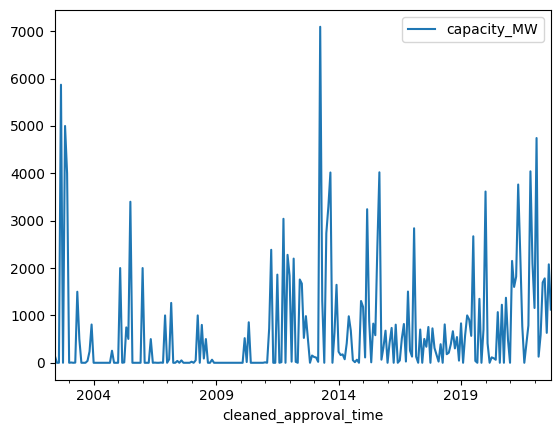

In [833]:
df_new.resample('M', on="cleaned_approval_time").sum().plot()

# Clean "Type" from df_new

In [834]:
df_new

,owner,company,address,type,capacity_MW,approval_date,prep_time,note,year,month,cleaned_approval_time
0,이건우,강원풍력발전(주),강원도 평창군 도암면횡계리,풍력,98.00,2002-6-11,2005.10.31,신규,2002,06,2002-06-01
1,후란쓰이스링거,코리아카본블랙(주)여수발전소,전남 여수시 월내동 350,부생가스,36.40,2002-6,2002.8.31,신규,2002,06,2002-06-01
2,후란쓰이스링거,코리아카본블랙(주)부평발전소,인천시 부평구 갈산1동94,부생가스,12.50,2002-6,2002.8.31,신규,2002,06,2002-06-01
3,이호인,(주)상원이엔씨매립가스,인천시 서구 백석동 58,내연기관(매립가스),70.88,2002-9,2002.12.31,신규,2002,09,2002-09-01
4,김영철,한국중부발전(주)보령발전소,충남 보령시 오천면오포리 산 212,석탄,5800.00,2002-9,7호기‘08.6.308호기‘0...,신규,2002,09,2002-09-01
...,...,...,...,...,...,...,...,...,...,...,...
2707,박영실,오도해도리,전남 고흥군 도덕면 오마...,태양광,28.89,2022-09-21,2031-03-31,신규,2022,09,2022-09-01
2739,선선규,고흥솔라,전남 고흥군 도덕면 오마...,태양광,15.00,2022-09-20,2024-06-30,신규,2022,09,2022-09-01
2745,"정춘돌,페라다크파타나찬",조도풍력발전,전남 진도군 조도면 외병...,풍력(해상),517.08,2022-09-21,2031-10-31,신규,2022,09,2022-09-01
2746,"윤의순,송홍렬",문도해상풍력,근 )전남 여수시 거문도 ...,풍력(해상),440.00,2022-09-21,2031-06-30,신규,2022,09,2022-09-01


In [835]:
df_new.type = df_new.type.str.replace(" ", "")
len(df_new.type.unique())

/var/folders/_c/dcjy1m9109bd_sq8l8j8zsdr0000gn/T/ipykernel_42160/2502575829.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.type = df_new.type.str.replace(" ", "")


218

In [836]:
df_new.company = df_new.company.str.replace("영암태 전", "영암태양광발전")
df_new.address = df_new.address.str.replace("양광발 전", "전")
df_new.loc[956, "type"] = "태양광"
df_new.loc[1667, "type"] = "태양광"
df_new.loc[2572, "type"] = "풍력"

/var/folders/_c/dcjy1m9109bd_sq8l8j8zsdr0000gn/T/ipykernel_42160/1137911547.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.company = df_new.company.str.replace("영암태 전", "영암태양광발전")
/var/folders/_c/dcjy1m9109bd_sq8l8j8zsdr0000gn/T/ipykernel_42160/1137911547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.address = df_new.address.str.replace("양광발 전", "전")


In [862]:
df_new.type.value_counts().head(20)

풍력               305
태양광              195
연료전지(LNG)        119
연료전지              64
풍력(해상)            41
연료전지(NG)          28
신재생(연료전지)         24
LNG               14
신재생(풍력)            8
열병합발전              8
열병합(LNG)           8
복합화력               8
바이오매스소각열           8
원자력                8
LNG복합              7
신재생(목질계바이오매스)      7
LNG복합화력            6
태양광(수상)            6
열병합                5
집단에너지              5
Name: type, dtype: int64

In [860]:
df_new['cleaned_type'] = np.nan

df_new.loc[df_new.type.str.contains("풍력", na=False), 'cleaned_type'] = "wind"
df_new.loc[df_new.type.str.contains("태양광", na=False), 'cleaned_type'] = "solar"
df_new.loc[df_new.type.str.contains("석탄", na=False), 'cleaned_type'] = "coal"
df_new.loc[df_new.type.str.contains("유연탄", na=False), 'cleaned_type'] = "coal"
df_new.loc[df_new.type.str.contains("열병합", na=False), 'cleaned_type'] = "coal"
df_new.loc[df_new.type.str.contains("복합", na=False), 'cleaned_type'] = "coal"
df_new.loc[df_new.type.str.contains("폐열", na=False), 'cleaned_type'] = "coal"
df_new.loc[df_new.type.str.lower().str.contains("ng", na=False), 'cleaned_type'] = "gas"
df_new.loc[df_new.type.str.contains("가스", na=False), 'cleaned_type'] = "gas"
df_new.loc[df_new.type.str.contains("바이오", na=False), 'cleaned_type'] = "bioenergy"
df_new.loc[df_new.type.str.contains("목질계", na=False), 'cleaned_type'] = "bioenergy"
df_new.loc[df_new.type.str.contains("우드칩", na=False), 'cleaned_type'] = "bioenergy"
df_new.loc[df_new.type.str.contains("원자력", na=False), 'cleaned_type'] = "nuclear"
df_new.loc[df_new.type.str.contains("수력", na=False), 'cleaned_type'] = "hydro"
df_new.loc[df_new.type.str.contains("양수", na=False), 'cleaned_type'] = "hydro"
# df_new.loc[df_new.type.str.lower().str.contains("srf", na=False), 'cleaned_type'] = "srf"
# df_new.loc[df_new.type.str.lower().str.contains("생활", na=False), 'cleaned_type'] = "srf"
# df_new.loc[df_new.type.str.lower().str.contains("폐기물", na=False), 'cleaned_type'] = "srf"
# df_new.loc[df_new.type.str.lower().str.contains("페기물", na=False), 'cleaned_type'] = "srf"
# df_new.loc[df_new.type.str.lower().str.contains("고체연료", na=False), 'cleaned_type'] = "srf"
# df_new.loc[df_new.type.str.lower().str.contains("고형연료", na=False), 'cleaned_type'] = "srf"
# df_new.loc[df_new.type.str.lower().str.contains("연료전지", na=False), 'cleaned_type'] = "hydrogen fuel cells"
# df_new.loc[df_new.type.str.lower().str.contains("조력", na=False), 'cleaned_type'] = "ocean"
# df_new.loc[df_new.type.str.lower().str.contains("해양", na=False), 'cleaned_type'] = "ocean"
# df_new.loc[df_new.type.str.lower().str.contains("스팀", na=False), 'cleaned_type'] = "steam"
# df_new.loc[df_new.type.str.lower().str.contains("증기", na=False), 'cleaned_type'] = "steam"

df_new.loc[df_new.cleaned_type.isna(), 'cleaned_type'] = "others"

# df_new[df_new.type.str.contains("수력", na=False)].type.value_counts().head(30)

/var/folders/_c/dcjy1m9109bd_sq8l8j8zsdr0000gn/T/ipykernel_42160/3909342088.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['cleaned_type'] = np.nan


In [869]:
df_cleaned = df_new[['cleaned_type', 'capacity_MW', 'address', 'year', 'company', 'owner']]
df_cleaned.head(30)

,cleaned_type,capacity_MW,address,year,company,owner
0,wind,98.00,강원도 평창군 도암면횡계리,2002,강원풍력발전(주),이건우
1,gas,36.40,전남 여수시 월내동 350,2002,코리아카본블랙(주)여수발전소,후란쓰이스링거
2,gas,12.50,인천시 부평구 갈산1동94,2002,코리아카본블랙(주)부평발전소,후란쓰이스링거
3,gas,70.88,인천시 서구 백석동 58,2002,(주)상원이엔씨매립가스,이호인
4,coal,5800.00,충남 보령시 오천면오포리 산 212,2002,한국중부발전(주)보령발전소,김영철
5,coal,4000.00,충남 태안군 원북면방갈리,2002,한국서부발전(주)태안화력발전소,이영철
7,gas,1000.00,충남 당진군 송악면부곡1리,2002,LG에너지(주)부곡발전소,조방래
9,coal,4000.00,충남 당진군 석문면교로리 산 974,2002,한국동서발전(주)당진화력발전소,이용오
10,wind,6.00,경남 양산시 원동면대리 산 93-4,2003,(주)코에지 양산풍력발전소,문무길
11,gas,3.46,대전시 유성구 금고동산21,2003,대전시금고동쓰레기매립가스발전소,이돈영


In [870]:
df_cleaned_reduced = df_cleaned[["cleaned_type", "capacity_MW", "year"]].copy()

In [871]:
df_cleaned_reduced = df_cleaned_reduced.groupby(['year', 'cleaned_type']).sum().reset_index()

In [866]:
# df_cleaned.to_csv("cleaned_df.csv", index=False)

In [872]:
minjus_favorite_df = pd.pivot(df_cleaned_reduced, index="year", columns="cleaned_type", values="capacity_MW").fillna(0).reset_index()

In [873]:
minjus_favorite_df.to_csv("minjus_favorite_permitting_data.csv", index=False)